In [1]:
import numpy as np
import pickle
import pandas as pd
import os
from os.path import join
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from scipy import stats
import xgboost as xgb
import random
from hyperopt import fmin, rand, hp, Trials
rstate = np.random.default_rng(42)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl

datasets_dir = "../../data"
# plt.style.use('CCB_plot_style_0v4.mplstyle')
# c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
# high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']

## Loading training, testing and validation data:

In [2]:
split = "secondary"

data_train = pd.read_pickle(join(datasets_dir, "splits", split, "training_data.pkl"))
data_test = pd.read_pickle(join(datasets_dir, "splits", split, "test_data.pkl"))
data_val = pd.read_pickle(join(datasets_dir, "splits", split, "val_data.pkl"))

# data_train["geomean_Km"] = np.log10(data_train["geomean_Km"])
# data_test["geomean_Km"] = np.log10(data_test["geomean_Km"])

data_train["log10_Km"] = np.log10(data_train["Km"])
data_test["log10_Km"] = np.log10(data_test["Km"])
data_val["log10_Km"] = np.log10(data_val["Km"])

data_train.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_test.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_val.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)

data_train['Temperature'] = data_train['Temperature'].replace('-', np.nan)
data_test['Temperature'] = data_test['Temperature'].replace('-', np.nan)
data_val['Temperature'] = data_val['Temperature'].replace('-', np.nan)
data_train['pH'] = data_train['pH'].replace('-', np.nan)
data_test['pH'] = data_test['pH'].replace('-', np.nan)
data_val['pH'] = data_val['pH'].replace('-', np.nan)
data_train['Type'] = data_train['Type'].replace('wildtype', 1)
data_train['Type'] = data_train['Type'].replace('mutant', 2)
data_test['Type'] = data_test['Type'].replace('wildtype', 1)
data_test['Type'] = data_test['Type'].replace('mutant', 2)
data_val['Type'] = data_val['Type'].replace('wildtype', 1)
data_val['Type'] = data_val['Type'].replace('mutant', 2)

data_train['MACCS FP'] = data_train['MACCS FP'].astype(str)
data_test['MACCS FP'] = data_test['MACCS FP'].astype(str)
data_val['MACCS FP'] = data_val['MACCS FP'].astype(str)

len(data_train), len(data_test), len(data_val)

(206, 52, 20)

In [3]:
train_indices = list(np.load(join(datasets_dir, "splits", split, "CV_train_indices_Seed plants.npy"), allow_pickle = True))
test_indices = list(np.load(join(datasets_dir, "splits", split, "CV_test_indices_Seed plants.npy"), allow_pickle = True))

## 1. Training a model with enzyme and main substrate information (ESM-2/MACCS) + Temperature + pH :

#### (a) Creating input matrices:

In [4]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train['GNN FP'])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test['GNN FP'])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [5]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [6]:
# print(best)

In [7]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 1, 'num_rounds': 200, 'reg_alpha': 0.6, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.05, 'max_delta_step': 5, 'max_depth': 3, 'min_child_weight': 6, 'num_rounds': 150, 'reg_alpha': 0.6, 'reg_lambda': 0.3}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.09, 'max_delta_step': 2, 'max_depth': 7, 'min_child_weight': 4, 'num_rounds': 100, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.07, 'max_delta_step': 2, 'max_depth': 6, 'min_child_weight': 6, 'num_rounds': 150, 'reg_alpha': 0.9, 'reg_lambda': 0.6}
else:
    param = {"random_state": 42, 'learning_rate': 0.04, 'max_delta_step': 5, 'max_depth': 9, 'min_child_weight': 1, 'num_rounds': 150, 'reg_alpha': 0.9, 'reg_lambda': 0.9}

#### (c) Training and validating model:

In [8]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [9]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2_gnn_fp.npy"), np.array(R2))

[0.712259063877006, -0.13191058439126502, 0.013143524862279973, 0.2966060264071361, 0.9411982273425176]
[0.0002204918446601779, 0.0005151062560342511, 0.00030529855312018086, 0.0008552835368452709, 0.00016442503507349933]
[0.44016384769737815, -0.2574194978632032, -0.10336538466886336, 0.013228000526173789, 0.6880447764474957]
[0.00011648343085550415, 0.000271149026878687, 0.00011975936486826634, 0.00023599212480105103, 8.282439042848223e-05]
[4.402867855541495e-05, 6.585325998510999e-05, 3.2948771929013146e-05, 7.634454788779882e-05, 2.9763541238050823e-05]


In [10]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = np.corrcoef(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0,1],20) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_ESM2_gnn_fp.npy"), test_Y)

0.6936321746967223 0.0001270533 0.39 5.85843e-05 2.30231e-05


In [11]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [12]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train['GNN FP'])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test['GNN FP'])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [13]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8716542655591116, 4.192884708598777e-17) 9.74660913959851e-05 0.6409367189975731


In [14]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 43.0
f1: 12.0
f2: 31.0
f3: 16.0
f4: 19.0
f5: 21.0
f6: 16.0
f7: 12.0
f8: 5.0
f9: 6.0
f10: 7.0
f11: 10.0
f12: 1.0
f13: 2.0
f14: 2.0
f15: 13.0
f16: 5.0
f17: 2.0
f18: 3.0
f19: 1.0
f20: 4.0
f21: 1.0
f22: 22.0
f23: 9.0
f24: 9.0
f26: 7.0
f27: 15.0
f29: 4.0
f30: 15.0
f31: 2.0
f32: 7.0
f34: 3.0
f38: 1.0
f39: 1.0
f40: 3.0
f41: 2.0
f42: 2.0
f43: 1.0
f45: 6.0
f46: 8.0
f47: 4.0
f48: 8.0
f49: 1.0
f51: 11.0
f52: 13.0
f54: 2.0
f55: 14.0
f56: 1.0
f57: 4.0
f62: 7.0
f63: 10.0
f64: 1.0
f69: 10.0
f70: 5.0
f71: 2.0
f72: 4.0
f73: 2.0
f74: 13.0
f75: 1.0
f76: 2.0
f78: 1.0
f80: 5.0
f82: 1.0
f83: 2.0
f85: 2.0
f86: 4.0
f87: 1.0
f89: 1.0
f91: 1.0
f93: 1.0
f95: 1.0
f97: 3.0
f99: 3.0
f100: 4.0
f101: 1.0
f106: 1.0
f107: 2.0
f110: 4.0
f111: 2.0
f114: 1.0
f119: 1.0
f122: 4.0
f123: 3.0
f125: 8.0
f126: 1.0
f127: 4.0
f129: 1.0
f131: 1.0
f136: 14.0
f137: 4.0
f138: 1.0
f139: 2.0
f140: 1.0
f141: 3.0
f142: 1.0
f145: 3.0
f147: 4.0
f148: 2.0
f150: 1.0
f154: 1.0
f155: 6.0
f158: 2.0
f160: 1.0
f161: 5.0
f162: 1.0
f163

##### Validating model:

In [15]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

In [16]:
# pd.DataFrame(list(chain(*data_val["Km_values"]))).describe()

In [17]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(0.05805174245274695, 0.8079253608401846) 0.002143757653247468 -0.13806254848111799 0.0007787960579227445 0.0001149550273877403


In [18]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# import matplotlib.cm as cmx

# plt.scatter(val_Y,y_val_pred, c='blue', edgecolors='black',s=15)
    
# plt.xlim(-6,2)
# plt.ylim(-6,2)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlabel('Real value', fontsize=15)
# plt.ylabel('Estimated value', fontsize=15)
# plt.title('Predictions', fontsize=15)
# plt.axline((1, 1), slope=1, c='red')
# plt.show()

In [19]:
# data_combined = pd.concat([data_train, data_test],ignore_index=True)

In [20]:
# def calculate_identity_ignore_gaps(seq1, seq2):
#     identical_residues = sum([1 for x, y in zip(seq1, seq2) if x == y and x != "-"])
#     pid = identical_residues / sum([1 for x in seq1 if x != "-"]) 
#     return pid

# from Bio import Align
# from Bio.Align import substitution_matrices

# data_val["max_identity"] = np.nan

# aligner=Align.PairwiseAligner()
# aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
# aligner.mode = "global"
# aligner.extend_gap_score = -0.5
# aligner.open_gap_score = -10

# for i in data_val.index:
#     identities = []
#     for j in data_combined.index:
#         seq1 = str(data_val["Sequence"][i])
#         seq2 = str(data_combined["Sequence"][j])
#         if 'U' in seq1:
#             seq1 = seq1.replace('U', 'C')
#         if 'U' in seq2:
#             seq2 = seq2.replace('U', 'C')
#         alignments = aligner.align(seq1, seq2)
#         identities.append(calculate_identity_ignore_gaps(alignments[0][0], alignments[0][1]))
#     data_val["max_identity"][i] = max(identities)

In [21]:
# data_val["max_identity"] = data_val["max_identity"]*100

In [22]:
# import matplotlib.pyplot as plt
# import sklearn.metrics as sk
# import math

# fig, ax = plt.subplots(figsize= (10,8))
# plt.rcParams.update({'font.size': 28})

# splits = ["0-40%", "40-80%", "80-99%", "99-100%"]
# lower_bounds = [0,40,80,99]
# upper_bounds = [40,80,99,100]

# points1 = []
# points2 = []
# n_points1, n_points2 = [], []

# for i, split in enumerate(splits):

#     lb, ub = lower_bounds[i], upper_bounds[i]
    
#     help_df = data_val.loc[data_val["max_identity"]>= lb].loc[data_val["max_identity"]<= ub]
#     y_true = np.array([10**x for x in help_df["log10_Km"]])
#     y_pred = np.array([10**x for x in help_df["Estimate Km"]])
#     n_km = len(y_pred)
#     R2 =  sk.r2_score(y_true, y_pred)
#     abs_error = abs(y_true - y_pred)
#     rmse = math.sqrt(np.mean(abs(y_true - y_pred)**2))
#     print(len(y_true))
#     print(split, R2, rmse)
#     points1.append(R2)
#     points2.append(rmse)
#     n_points1.append(n_km)


# ticks2 = np.array(range(len(splits)))
# labs = splits
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((-0.1,2.5))
# # plt.xlim((-0.2, 3.2))
# plt.legend(loc = "lower right", fontsize=20)
# plt.ylabel('RMSE')
# plt.xlabel('Enzyme sequence identity')
# ax.yaxis.set_label_coords(-0.15, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.13)

# plt.plot([-0.15,4], [0,0], color='grey', linestyle='dashed')


# plt.plot([0,1,2,3], points2, c= "black", linewidth=2)

# for i, split in enumerate(splits):
#     points1.append(R2)
    
#     if i ==0:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")

#     else:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")
            
     
# plt.savefig(join("..","..", "data", split, "sequence_identity.png"))
# plt.show()

In [23]:
# EC_km_pred =[[] for _ in range(6)]
# EC_km =[[] for _ in range(6)]
# for ind in data_val.index:
#     try:
#         EC = int(data_val["ECs"][ind][0][0])
#         EC_km[EC-1].append(data_val["log10_Km"][ind])
#         EC_km_pred[EC-1].append(data_val["Estimate Km"][ind])
#     except IndexError:
#         pass

In [24]:
# fig, ax = plt.subplots(figsize= (8,8))
# plt.rcParams.update({'font.size': 28})

# classes = [str(i) for i in range(1,7)]

# for i in range(len(EC_km)):
    
#     circle = plt.Circle((np.mean(EC_km[i]), np.mean(EC_km_pred[i]) ),
#                         np.sqrt(len(EC_km_pred[i]))/300, color='navy', fill = True)
#     ax.add_artist(circle)
#     if i ==5:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_km[i])+0.01, np.mean(EC_km_pred[i])-0.05), fontsize=17, c='red', weight = "bold")
#     else:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_km[i])+0.03, np.mean(EC_km_pred[i])-0.01), fontsize=17, c='red', weight = "bold")
    

# # ticks2 = [0.2, 0.6,1,1.4,1.8]
# # labs = ticks2
# # ax.set_xticks(ticks2)
# # ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# # ax.tick_params(axis='x', length=0, rotation = 0)

# # ax.set_yticks(ticks2)
# # ax.set_yticklabels(labs,  y= -0.03, fontsize=26)
# # ax.tick_params(axis='y', length=0, rotation = 0)

# plt.ylim((-6,-1))
# plt.xlim((-6, -1))
# plt.legend(loc = "upper left", fontsize=20)
# plt.xlabel('mean measured \n $k_{m}$ value on $\log_{10}$-scale')
# plt.ylabel('mean predicted \n $k_{m}$ value on $\log_{10}$-scale')
# ax.yaxis.set_label_coords(-0.15, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.13)
# plt.axline((1, 1), slope=1, c='grey', alpha = 0.3, linestyle='dashed')
# plt.savefig(join("..", "..", "data", split, "EC_classes_mean_km.png"))
# plt.show()

In [25]:
# import scipy

# train_fps = [np.array(list(data_combined["MACCS FP"][ind])).reshape(1,-1) for ind in data_combined.index]
# test_fps = [np.array(list(data_val["MACCS FP"][ind])).reshape(1,-1) for ind in data_val.index]

# max_sim = []

# for fp in test_fps:
#     jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
#     max_sim.append(np.max(jaccard_sim))
    
# data_val["substrate_sim"] = max_sim

# data_val["substrate_sim"]= (data_val["substrate_sim"] - np.min(data_val["substrate_sim"]))
# data_val["substrate_sim"] = data_val["substrate_sim"]/np.max(data_val["substrate_sim"])

In [26]:
# data_val["global_sim"] = (data_val["max_identity"]/100)*data_val["substrate_sim"]

In [27]:
# data_val.describe()

In [28]:
# import matplotlib.pyplot as plt
# import math
# import scipy as sci
# help_df = data_val

# sim_bins_lb = [0.0, 0.4, 0.8]
# sim_bins_ub = [0.4, 0.8, 1]
# r2_scores, n_points, pearson_r, rmse = [], [], [], []
# for i in range(len(sim_bins_lb)):
#     help_df2 = help_df.loc[help_df["global_sim"] <= sim_bins_ub[i]].loc[help_df["global_sim"] >= sim_bins_lb[i]]
#     pred = np.array([10**x for x in help_df2["log10_Km"]])
#     true = np.array([10**x for x in help_df2["Estimate Km"]])
#     r2_scores.append(sk.r2_score(true, pred))
#     pearson_r.append(sci.stats.pearsonr(true, pred)[0])
#     rmse.append(math.sqrt(np.mean(abs(true - pred)**2)))
#     n_points.append(len(pred))
#     print("%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]), r2_scores[-1], pearson_r[-1], rmse[-1], len(pred))
    

# plt.rcParams.update({'font.size': 24})

# fig, ax = plt.subplots(figsize= (8,6))

# for i in range(len(sim_bins_lb)):    
#     plt.scatter(i, rmse[i], c='navy', marker="o", linewidths= 8)
#     ax.annotate(n_points[i], (i-0.08, rmse[i]+0.05), fontsize=17, c= "black", weight = "bold")

    
# plt.xlabel('Reaction similarity score')
# plt.ylabel('RMSE')
# ax.yaxis.set_label_coords(-0.2, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.23)

# ticks2 = np.array(range(len(sim_bins_lb)))
# labs = ["%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]) for i in range(len(sim_bins_lb))]
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=20)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((0.5,2))
# #plt.xlim((-0.5, 3.2))

# # plt.plot([-0.49, 4], [0,0], color='grey', linestyle='dashed')
# #plt.savefig(join("..","..", "data", split, "figures", "Reaction_Similarity_Score.eps"))
# plt.show()

## 2. Training a model with enzyme and reaction information (ESM-2/diff_fp) + Temperature + pH :

#### (a) Creating input matrices:

In [29]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [30]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [31]:
# print(best)

In [32]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 4, 'num_rounds': 150, 'reg_alpha': 0.3, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4, 'max_depth': 5, 'min_child_weight': 2, 'num_rounds': 150, 'reg_alpha': 0.3, 'reg_lambda': 0.5}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.08, 'max_delta_step': 4, 'max_depth': 10, 'min_child_weight': 3, 'num_rounds': 150, 'reg_alpha': 0.3, 'reg_lambda': 0.5}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 5, 'max_depth': 7, 'min_child_weight': 3, 'num_rounds': 100, 'reg_alpha': 0.6, 'reg_lambda': 0.6}
else:
    param = {"random_state": 42, 'learning_rate': 0.08, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 1, 'num_rounds': 150, 'reg_alpha': 0.6, 'reg_lambda': 0.7}


#### (c) Training and validating model:

In [33]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [34]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2_diff_fp.npy"), np.array(R2))

[0.526793055079571, 0.1700060767512365, -0.035479601756666465, 0.04593716802728603, 0.5929076452629232]
[0.00027849678536720577, 0.00048341180068461355, 0.00030698051122754846, 0.0008803492229131115, 0.00026130780896042177]
[0.10686676244024462, -0.10744211965482275, -0.11555624757061733, -0.04545793435846357, 0.21211804723762995]
[0.00011890249884776927, 0.0002326959009884453, 0.00011732167361809171, 0.00023348257941770237, 9.291775109624213e-05]
[4.3935911524319436e-05, 3.2126165230534316e-05, 2.7515805348083702e-05, 5.175251543612183e-05, 2.2740583653679436e-05]


In [35]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_ESM2_diff_fp.npy"), test_Y)

0.476 0.0001459171 0.195 6.07771e-05 1.65204e-05


In [36]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [37]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [38]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.773257276835051, 1.8371108355474325e-11) 0.00011989066280565835 0.45670636527444297


##### Validating model:

In [39]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

In [40]:
# pd.DataFrame(list(chain(*data_val["Km_values"]))).describe()

In [41]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.24531394760451494, 0.29719157397868873) 0.00215803361341994 -0.15327045440497122 0.0007761236496223211 7.097105572640298e-05


## 3. Training a model with enzyme, main substrate (MACCS fp) and reaction information (ESM-2/diff_fp) + Temperature + pH :

#### (a) Creating input matrices:

In [42]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [43]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [44]:
# print(best)

In [45]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.09, 'max_delta_step': 1, 'max_depth': 4, 'min_child_weight': 6, 'num_rounds': 200, 'reg_alpha': 0.8, 'reg_lambda': 0.3}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4, 'max_depth': 5, 'min_child_weight': 2, 'num_rounds': 150, 'reg_alpha': 0.3, 'reg_lambda': 0.5}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.06, 'max_delta_step': 4, 'max_depth': 3, 'min_child_weight': 5, 'num_rounds': 200, 'reg_alpha': 0.2, 'reg_lambda': 0.2}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.04, 'max_delta_step': 2, 'max_depth': 6, 'min_child_weight': 6, 'num_rounds': 200, 'reg_alpha': 0.8, 'reg_lambda': 0.9}
else:
    param = {"random_state": 42, 'learning_rate': 0.09, 'max_delta_step': 5, 'max_depth': 5, 'min_child_weight': 5, 'num_rounds': 150, 'reg_alpha': 0.2, 'reg_lambda': 0.6}

#### (c) Training and validating model:

In [46]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [47]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), np.array(R2))

[0.5259810956879604, 0.1182954424011315, 0.030526978655547946, 0.32699084794134714, 0.8583641434896496]
[0.0002658775297368224, 0.0004845023141852751, 0.0003055601319254288, 0.0008611018853330972, 0.0001822237828373374]
[0.18597236492921754, -0.11244424316659263, -0.10525691438084372, -0.00024335008507492262, 0.6168520627064236]
[0.00011573153159765395, 0.00024483091208398123, 0.00011723019837027846, 0.00022796808944951902, 8.093106167231557e-05]
[2.482024871521398e-05, 7.246230959778643e-05, 2.244813253836015e-05, 5.5931376107187946e-05, 1.3045890398064937e-05]


In [48]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_ESM2_gnn_fp_diff_fp.npy"), test_Y)

0.402 0.0001512587 0.135 5.95727e-05 1.59868e-05


In [49]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [50]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [51]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8905246210884016, 9.907260189585665e-19) 9.715656792969458e-05 0.6432136552787149


##### Validating model:

In [52]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

In [53]:
# pd.DataFrame(list(chain(*data_val["Km_values"]))).describe()

In [54]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.13319509423793982, 0.5756047509489909) 0.0021499859463372556 -0.14468501703009284 0.0007889947968597419 0.00013918870256358882


## 4. Training a model with enzyme information (ESM-2) + Temperature + pH:

#### (a) Creating input matrices:

In [55]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [56]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [57]:
# print(best)

In [58]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.08, 'max_delta_step': 5, 'max_depth': 6, 'min_child_weight': 4, 'num_rounds': 150, 'reg_alpha': 0.6, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.08, 'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 1, 'num_rounds': 200, 'reg_alpha': 1, 'reg_lambda': 0.2}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.05, 'max_delta_step': 1, 'max_depth': 7, 'min_child_weight': 5, 'num_rounds': 200, 'reg_alpha': 0.6, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.08, 'max_delta_step': 5, 'max_depth': 5, 'min_child_weight': 2, 'num_rounds': 150, 'reg_alpha': 0.9, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.07, 'max_delta_step' : 1, 'max_depth': 6, 'min_child_weight': 6, 'num_rounds': 200, 'reg_alpha': 1, 'reg_lambda': 0.6}

#### (c) Training and validating model:

In [59]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [60]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2.npy"), np.array(R2))

[0.4871572408063976, 0.016835854409076506, -0.01475021139113114, 0.3096808741574828, 0.5963081863912776]
[0.00028395539107088007, 0.000498812766476974, 0.0003082951533030138, 0.0008674991120977195, 0.00026954555123526923]
[0.07151238411940575, -0.1791299258177914, -0.12513143158213347, -0.015160405304329716, 0.1616589882607088]
[0.00011649575778439775, 0.00024454252664929404, 0.00012136759400365631, 0.00023197080156854493, 9.066298430823439e-05]
[3.1485585508387895e-05, 3.7932510961464575e-05, 3.471700013218737e-05, 3.535732095490062e-05, 2.288702891838941e-05]


In [61]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_ESM2.npy"), test_Y)

0.524 0.0001456432 0.198 5.89234e-05 2.48737e-05


In [62]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [63]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [64]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.6252710856791355, 7.212808717968775e-07) 0.00013162662318852612 0.3451356114449423


In [65]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 4.0
f1: 3.0
f3: 3.0
f4: 1.0
f5: 2.0
f7: 2.0
f8: 4.0
f9: 1.0
f10: 5.0
f11: 3.0
f12: 2.0
f14: 6.0
f17: 2.0
f19: 1.0
f23: 1.0
f24: 3.0
f30: 3.0
f31: 3.0
f35: 2.0
f36: 1.0
f37: 1.0
f38: 4.0
f40: 2.0
f42: 1.0
f44: 5.0
f45: 1.0
f46: 4.0
f47: 1.0
f49: 3.0
f51: 1.0
f52: 4.0
f54: 5.0
f55: 2.0
f56: 1.0
f58: 1.0
f60: 3.0
f64: 2.0
f66: 1.0
f71: 1.0
f72: 1.0
f75: 3.0
f83: 3.0
f84: 1.0
f91: 1.0
f92: 1.0
f93: 1.0
f94: 1.0
f95: 3.0
f97: 2.0
f99: 6.0
f100: 1.0
f106: 8.0
f107: 3.0
f108: 2.0
f111: 1.0
f112: 1.0
f113: 1.0
f119: 1.0
f125: 3.0
f127: 5.0
f132: 2.0
f135: 2.0
f140: 2.0
f141: 1.0
f148: 2.0
f149: 5.0
f150: 12.0
f156: 2.0
f157: 1.0
f162: 1.0
f164: 4.0
f169: 1.0
f170: 13.0
f172: 19.0
f176: 1.0
f177: 2.0
f178: 1.0
f180: 2.0
f181: 2.0
f185: 4.0
f192: 7.0
f195: 4.0
f196: 2.0
f197: 3.0
f198: 1.0
f199: 1.0
f201: 6.0
f205: 1.0
f206: 1.0
f209: 1.0
f214: 2.0
f217: 1.0
f220: 1.0
f221: 1.0
f223: 2.0
f225: 1.0
f228: 10.0
f235: 1.0
f236: 1.0
f238: 4.0
f242: 2.0
f243: 6.0
f254: 1.0
f260: 7.0
f264:

#### (e) Validating model:

In [66]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.09092464081633021, 0.7030280294838331) 0.002152009102983408 -0.14684034900775544 0.0007743314806783118 9.068195324952755e-05


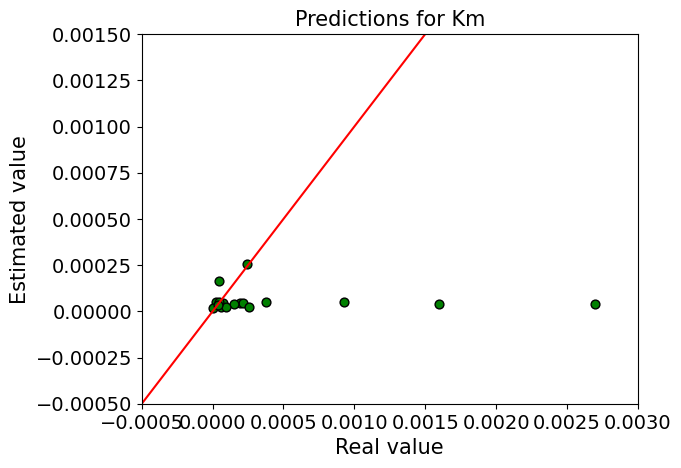

In [67]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.scatter([10**x for x in val_Y],[10**x for x in y_val_pred],c='green', edgecolors='black',s=40)
    
plt.xlim(-0.0005,0.003)
plt.ylim(-0.0005,0.0015)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value', fontsize=15)
plt.ylabel('Estimated value', fontsize=15)
plt.title('Predictions for Km', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

## 5. Training a model with main substrate information (MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [68]:
train_X = np.array(list(data_train['GNN FP']))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test['GNN FP']))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [69]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [70]:
# print(best)

In [71]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.05, 'max_delta_step': 2, 'max_depth': 6, 'min_child_weight': 3, 'num_rounds': 200, 'reg_alpha': 0.6, 'reg_lambda': 0.5}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.08, 'max_delta_step': 4, 'max_depth': 6, 'min_child_weight': 2, 'num_rounds': 50, 'reg_alpha': 1, 'reg_lambda': 0.5}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.06, 'max_delta_step': 1, 'max_depth': 9, 'min_child_weight': 5, 'num_rounds': 150, 'reg_alpha': 0.6, 'reg_lambda': 1}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.03, 'max_delta_step': 1, 'max_depth': 7, 'min_child_weight': 3, 'num_rounds': 150, 'reg_alpha': 0.7, 'reg_lambda': 0.2}
else:
    param = {"random_state": 42, 'learning_rate': 0.04, 'max_delta_step': 4, 'max_depth': 3, 'min_child_weight': 6, 'num_rounds': 100, 'reg_alpha': 0.6, 'reg_lambda': 0.1}

#### (c) Training and validating model:

In [72]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [73]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_gnn_fp.npy"), np.array(R2))

[0.20048239669261325, 0.5896957456063747, 0.17002387343376374, 0.13419817815756577, 0.3169318241121194]
[0.00030713075972670724, 0.0004257411832992769, 0.0002988482540867538, 0.0008726847651251482, 0.00027954421115631444]
[-0.08623178461308822, 0.14103025502026567, -0.05723445613598144, -0.027333337077096287, 0.09830973215126171]
[0.000146908466087426, 0.00019726729830796554, 0.00012025696246414877, 0.00023086136794220227, 0.00011688953376550764]
[3.4838415880381776e-05, 3.5570255588528626e-05, 3.4602710780501275e-05, 6.987935032027305e-05, 3.6037959400479275e-05]


In [74]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_gnn_fp.npy"), test_Y)

0.02 0.0001802165 -0.228 9.15454e-05 2.53954e-05


In [75]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [76]:
train_X = np.array(list(data_train["GNN FP"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["GNN FP"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [77]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.6705559599866642, 5.3729708505681804e-08) 0.00014243048684974525 0.2332217029831215


In [78]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 22.0
f1: 19.0
f2: 4.0
f4: 21.0
f5: 10.0
f6: 2.0
f7: 12.0
f8: 9.0
f9: 13.0
f12: 4.0
f14: 9.0
f16: 31.0
f17: 11.0
f18: 11.0
f19: 12.0
f21: 1.0
f22: 18.0
f24: 16.0
f25: 11.0
f26: 5.0
f29: 2.0
f34: 17.0
f35: 7.0
f37: 11.0
f39: 24.0
f41: 6.0
f42: 12.0
f43: 3.0
f45: 2.0
f46: 3.0
f50: 45.0
f51: 151.0


#### (e) Validating model:

In [79]:
val_X = np.array(list(data_val["GNN FP"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE,MedAE)

(-0.21820862033578536, 0.3553667798264027) 0.00214596461765405 -0.14040698922700767 0.0007829129141430566 0.00010355857986449015


## 6. Training a model with reaction information (diff-fp) + Temperature + pH:

#### (a) Creating input matrices:

In [80]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [81]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [82]:
# print(best)

In [83]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.03, 'max_delta_step': 2, 'max_depth': 9, 'min_child_weight': 4, 'num_rounds': 200, 'reg_alpha': 0.3, 'reg_lambda': 0.6}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.09, 'max_delta_step': 5, 'max_depth': 8, 'min_child_weight': 3, 'num_rounds': 150, 'reg_alpha': 0.8, 'reg_lambda': 0.2}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.03, 'max_delta_step': 5, 'max_depth': 7, 'min_child_weight': 4, 'num_rounds': 200, 'reg_alpha': 0.5, 'reg_lambda': 0.6}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.05, 'max_delta_step': 5, 'max_depth': 7, 'min_child_weight': 4, 'num_rounds': 200, 'reg_alpha': 0.9, 'reg_lambda': 0.2}
else:
    param = {"random_state": 42, 'learning_rate': 0.06, 'max_delta_step': 3, 'max_depth': 3, 'min_child_weight': 3, 'num_rounds': 200, 'reg_alpha': 0.4, 'reg_lambda': 0.5}

#### (c) Training and validating model:

In [84]:

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [85]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_diff_fp.npy"), np.array(R2))

[0.5677031774152325, 0.5508369215255029, 0.13034056237231872, 0.2542880115838869, 0.16611758160147166]
[0.0002442398306063694, 0.00044698454409231703, 0.00030439257470662334, 0.0008684682485782389, 0.0002948660908243709]
[0.31307573331819805, 0.05317099414302917, -0.096826591683842, -0.01742986821556336, -0.003242773477046823]
[0.0001241997339462623, 0.00020076545888160198, 0.00011763127468796472, 0.00022278984839259466, 9.853350760043308e-05]
[3.24616845626503e-05, 3.770670536476129e-05, 2.4052792021037533e-05, 3.12880914253343e-05, 2.787376233781662e-05]


In [86]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_diff_fp.npy"), test_Y)

0.171 0.0001649833 -0.029 6.68308e-05 1.57636e-05


In [87]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [88]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [89]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.8008211225299675, 1.023382532076462e-12) 0.00013128122173974976 0.3485679616643709


In [90]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f7: 1.0
f11: 1.0
f28: 27.0
f29: 18.0
f60: 4.0
f61: 3.0
f75: 13.0
f94: 6.0
f95: 2.0
f111: 1.0
f115: 2.0
f116: 22.0
f124: 6.0
f125: 7.0
f137: 7.0
f138: 1.0
f157: 18.0
f158: 3.0
f159: 8.0
f178: 5.0
f190: 4.0
f192: 4.0
f200: 5.0
f201: 4.0
f212: 5.0
f216: 2.0
f223: 1.0
f231: 2.0
f246: 10.0
f255: 3.0
f270: 13.0
f283: 1.0
f334: 13.0
f335: 3.0
f377: 4.0
f412: 4.0
f563: 1.0
f571: 3.0
f584: 4.0
f637: 4.0
f682: 14.0
f704: 4.0
f776: 2.0
f778: 4.0
f798: 3.0
f823: 14.0
f837: 1.0
f863: 13.0
f883: 14.0
f888: 1.0
f909: 1.0
f910: 3.0
f938: 2.0
f939: 9.0
f944: 3.0
f952: 13.0
f953: 6.0
f1005: 5.0
f1009: 2.0
f1018: 2.0
f1019: 5.0
f1032: 1.0
f1040: 2.0
f1048: 4.0
f1049: 7.0
f1050: 3.0
f1051: 3.0
f1077: 13.0
f1088: 1.0
f1096: 2.0
f1097: 5.0
f1099: 2.0
f1104: 2.0
f1105: 2.0
f1113: 1.0
f1115: 4.0
f1162: 13.0
f1206: 1.0
f1208: 2.0
f1214: 2.0
f1221: 5.0
f1277: 23.0
f1290: 11.0
f1293: 1.0
f1302: 8.0
f1309: 6.0
f1318: 1.0
f1350: 4.0
f1353: 2.0
f1358: 2.0
f1372: 7.0
f1373: 7.0
f1410: 5.0
f1426: 11.0
f1440:

#### (e) Validating model:

In [91]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(-0.026258404194839012, 0.9124980438885376) 0.0021378004747610578 -0.13174632899619887 0.0008448064218940633 0.0001306058927739701


## 7. Training a model with reaction and main substrate information (diff-fp/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [92]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [93]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", np.linspace(0.01, 0.1, 10)),
#     "max_depth": hp.choice("max_depth", np.linspace(3,10,8)),
#     #"subsample": hp.quniform("subsample", 0.5, 1),
#     "reg_lambda": hp.choice("reg_lambda", np.linspace(0, 1, 11)),
#     "reg_alpha": hp.choice("reg_alpha", np.linspace(0, 1, 11)),
#     "max_delta_step": hp.choice("max_delta_step", np.linspace(1, 5, 5)),
#     "min_child_weight": hp.choice("min_child_weight", np.linspace(1, 6, 6)),
#     "num_rounds":  hp.choice("num_rounds", np.linspace(50, 200, 4))}


# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials)

In [94]:
# print(best)

In [95]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4, 'max_depth': 7, 'min_child_weight': 2, 'num_rounds': 200, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.07, 'max_delta_step': 5, 'max_depth': 5, 'min_child_weight': 5, 'num_rounds': 200, 'reg_alpha': 0.8, 'reg_lambda': 0.4}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.06, 'max_delta_step': 5, 'max_depth': 6, 'min_child_weight': 4, 'num_rounds': 200, 'reg_alpha': 0.4, 'reg_lambda': 0.9}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.09, 'max_delta_step': 5, 'max_depth': 6, 'min_child_weight': 5, 'num_rounds': 150, 'reg_alpha': 0.7, 'reg_lambda': 1}
else:
    param = {"random_state": 42, 'learning_rate': 0.07, 'max_delta_step': 2, 'max_depth': 9, 'min_child_weight': 3, 'num_rounds': 200, 'reg_alpha': 0.2, 'reg_lambda': 0.9}

#### (c) Training and validating model:

In [96]:

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [97]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(R2))

[0.6125042450242191, 0.5351191773256632, 0.07097604662058227, 0.7364112800392792, 0.6033355868639574]
[0.0002514592763138572, 0.00042457118709594355, 0.00030528517368467106, 0.0007867900738518901, 0.0002533465382157636]
[0.2718661835417353, 0.1457449053830946, -0.10326867878943857, 0.1649464301134681, 0.2593955376044337]
[0.00013709142503288486, 0.000191717500389625, 0.0001144420242018666, 0.00020835310206154307, 9.611312756633567e-05]
[4.198833984851883e-05, 3.976653087950103e-05, 2.502658872099611e-05, 3.516790408571062e-05, 1.4317344946594623e-05]


In [98]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = np.corrcoef(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[1,0],20) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_gnn_fp_diff_fp.npy"), test_Y)

0.5176631383982937 0.0001415993 0.242 6.2332e-05 1.6074e-05


In [99]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [100]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [101]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9355173621562881, 3.048212484990304e-24) 7.860996616570964e-05 0.7664288961493375


In [102]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f4: 47.0
f5: 9.0
f6: 58.0
f7: 9.0
f11: 17.0
f13: 7.0
f22: 22.0
f23: 1.0
f28: 46.0
f29: 8.0
f31: 2.0
f36: 1.0
f43: 23.0
f52: 3.0
f60: 18.0
f61: 31.0
f71: 10.0
f72: 3.0
f74: 4.0
f75: 54.0
f77: 8.0
f90: 1.0
f94: 23.0
f95: 53.0
f97: 4.0
f106: 1.0
f115: 3.0
f116: 16.0
f119: 5.0
f124: 37.0
f125: 19.0
f134: 7.0
f137: 3.0
f138: 55.0
f146: 1.0
f157: 15.0
f158: 18.0
f159: 1.0
f161: 1.0
f162: 1.0
f169: 4.0
f178: 10.0
f181: 18.0
f190: 24.0
f192: 7.0
f193: 3.0
f194: 5.0
f195: 5.0
f200: 15.0
f201: 39.0
f202: 2.0
f203: 1.0
f207: 4.0
f232: 1.0
f241: 12.0
f246: 12.0
f254: 11.0
f255: 14.0
f283: 2.0
f307: 1.0
f311: 5.0
f312: 7.0
f314: 1.0
f332: 4.0
f334: 45.0
f335: 1.0
f374: 16.0
f377: 10.0
f412: 5.0
f431: 3.0
f443: 2.0
f476: 11.0
f477: 25.0
f529: 4.0
f563: 20.0
f570: 3.0
f571: 15.0
f584: 5.0
f585: 1.0
f630: 7.0
f648: 9.0
f649: 1.0
f682: 16.0
f704: 2.0
f706: 1.0
f728: 15.0
f754: 1.0
f764: 11.0
f776: 38.0
f778: 2.0
f780: 3.0
f783: 3.0
f786: 2.0
f796: 6.0
f798: 24.0
f808: 34.0
f823: 44.0
f837: 1.0

#### (e) Validating model:

In [103]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = np.corrcoef(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson[1,0], MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

0.24604087691850682 0.0020885194594232226 -0.0801692463669359 0.0007810419505414868 0.0001501192949155606
